<img src="https://letsgrowmore.in/wp-content/uploads/2021/05/growmore-removebg-preview-600x245.png" />

# Stock Market Prediction 

### Introduction to Stock Market Prediction using Stacked LSTM
Stock market prediction and forecasting using Stacked LSTM is a powerful approach for accurately predicting future stock prices. Stacked Long Short-Term Memory (LSTM) networks, a type of recurrent neural network (RNN), excel in capturing long-term dependencies in sequential data. By stacking multiple LSTM layers, we create a robust model capable of learning complex relationships within stock market data.

The objective is to develop a model that leverages historical price and volume data, along with other relevant factors, to predict stock prices. Stacked LSTM models consider various features and input variables, making them versatile for short-term trading strategies and long-term investment analysis.

However, stock market prediction is challenging due to volatility and external factors. Stacked LSTM models are valuable decision support tools, but not infallible predictors. This project explores the architecture, training, feature engineering, data preprocessing, and evaluation metrics for Stacked LSTM models. By implementing and fine-tuning the model, we aim to provide accurate predictions to assist investors and traders in making informed decisions.

### Step 1: Load the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
%matplotlib inline

In [2]:
# Load the data
df = pd.read_csv('https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv')
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


### Step 2: Explanatory Data Analysis(EDA)

In [3]:
# Checking for missing values
df.isnull().sum()

Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

In [4]:
# Converting the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
# Sorting the data by date
df = df.sort_values('Date')

# Resetting the index
df = df.reset_index(drop=True)

# Normalizing the 'Close' prices
scaler = MinMaxScaler(feature_range=(0, 1))
df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

In [6]:
# Descriptive statistics
df.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.000000,2.035000e+03,2035.000000
mean,149.713735,151.992826,147.293931,149.474251,0.279821,2.335681e+06,3899.980565
std,48.664509,49.413109,47.931958,48.732570,0.198987,2.091778e+06,4570.767877
min,81.100000,82.800000,80.000000,81.000000,0.000000,3.961000e+04,37.040000
25%,120.025000,122.100000,118.300000,120.075000,0.159722,1.146444e+06,1427.460000
50%,141.500000,143.400000,139.600000,141.100000,0.246324,1.783456e+06,2512.030000
75%,157.175000,159.400000,155.150000,156.925000,0.310253,2.813594e+06,4539.015000
max,327.700000,328.750000,321.650000,325.950000,1.000000,2.919102e+07,55755.080000


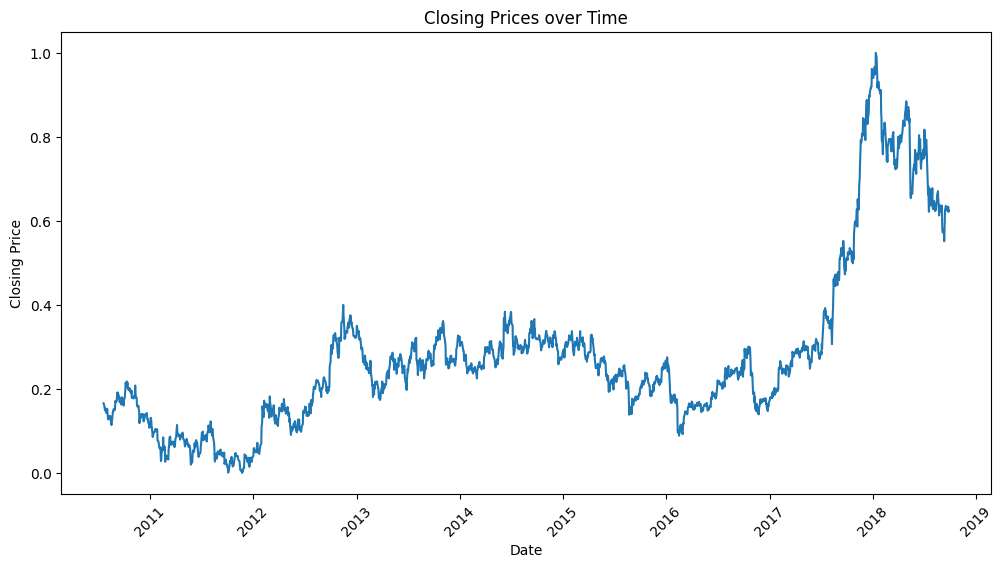

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'])
plt.title('Closing Prices over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.show()

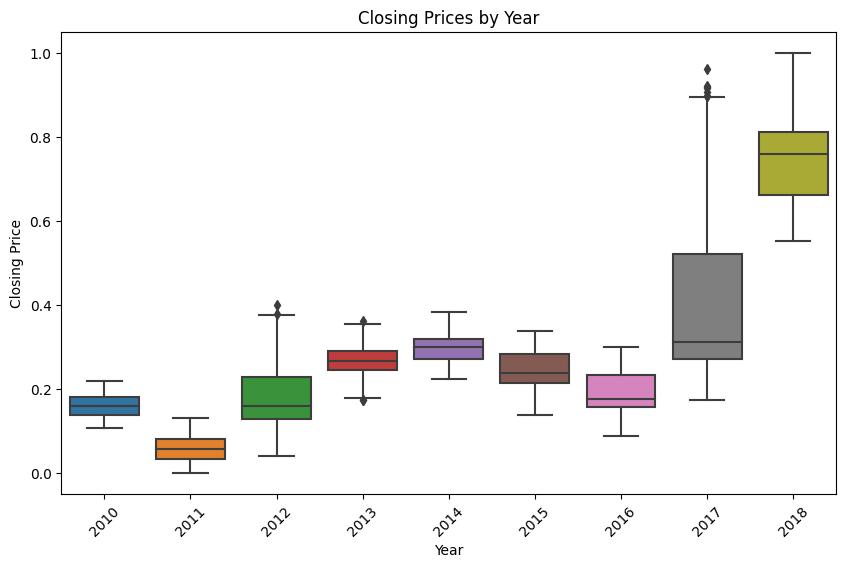

In [8]:
df['Year'] = df['Date'].dt.year

plt.figure(figsize=(10, 6))
sns.boxplot(x='Year', y='Close', data=df)
plt.title('Closing Prices by Year')
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.show()

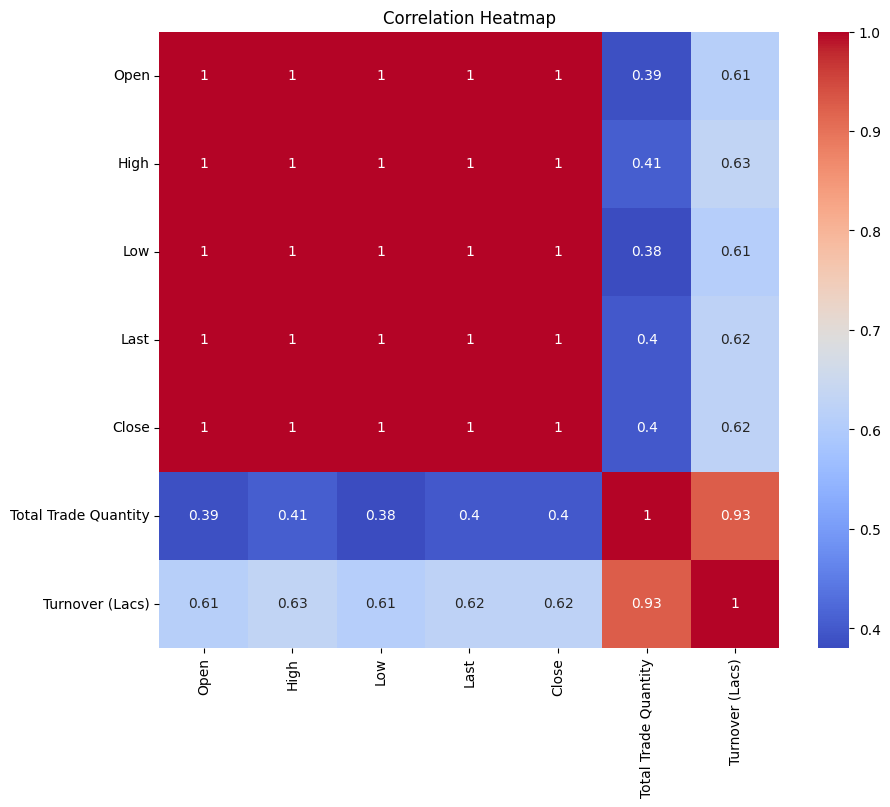

In [9]:
correlation_cols = ['Open', 'High', 'Low', 'Last', 'Close','Total Trade Quantity', 'Turnover (Lacs)']

correlation_matrix = df[correlation_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


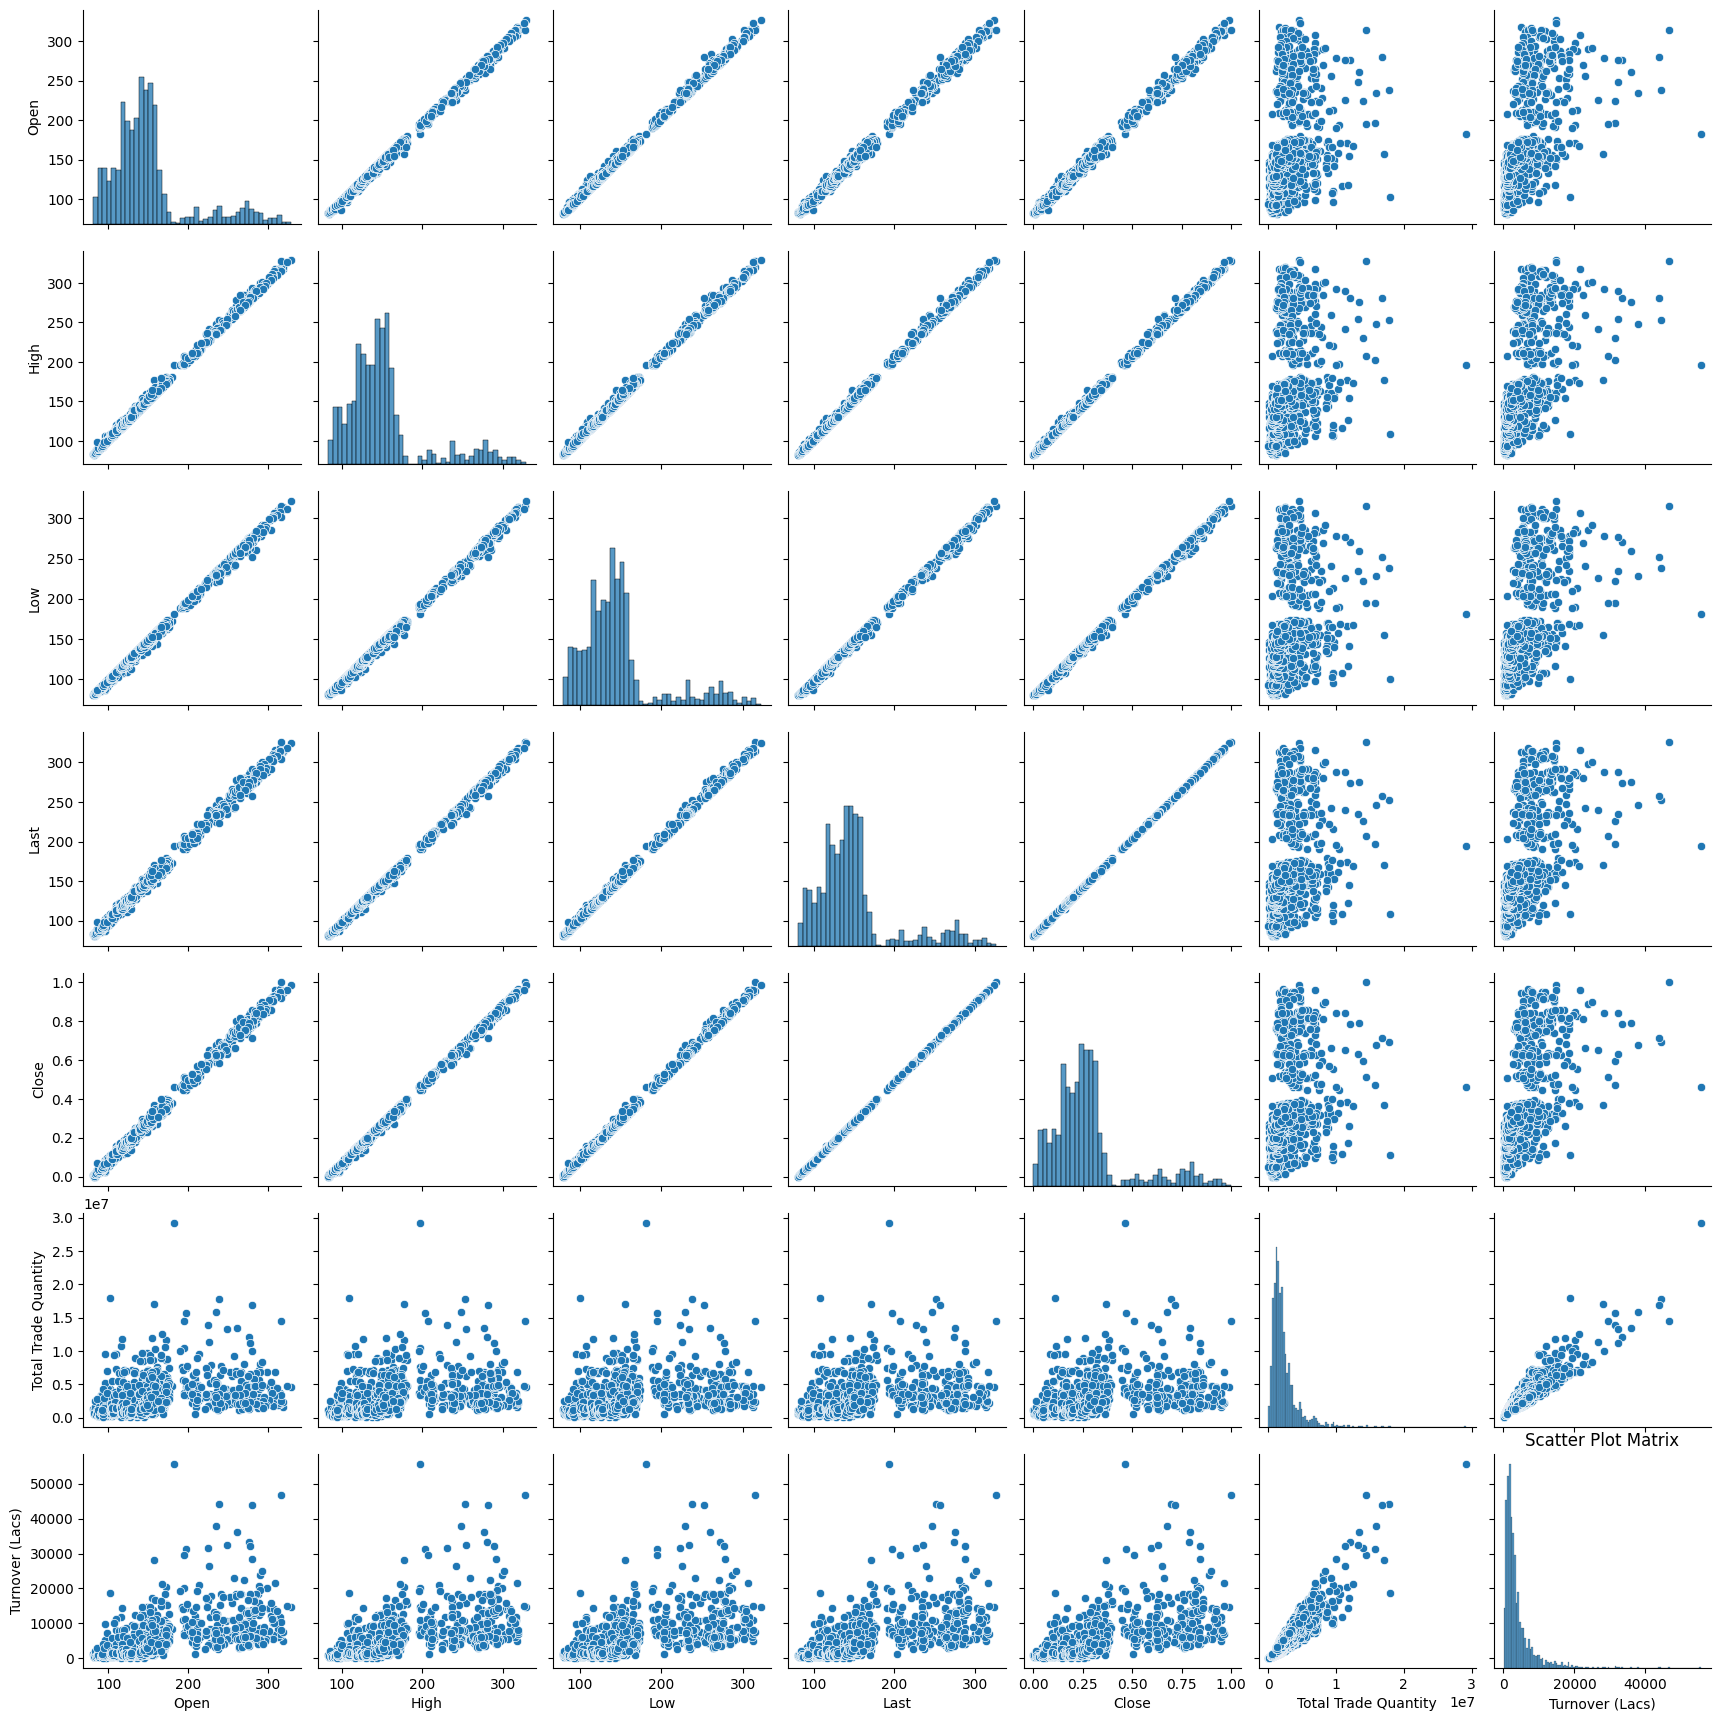

In [10]:
sns.pairplot(df[correlation_cols])
plt.title('Scatter Plot Matrix')
plt.show()

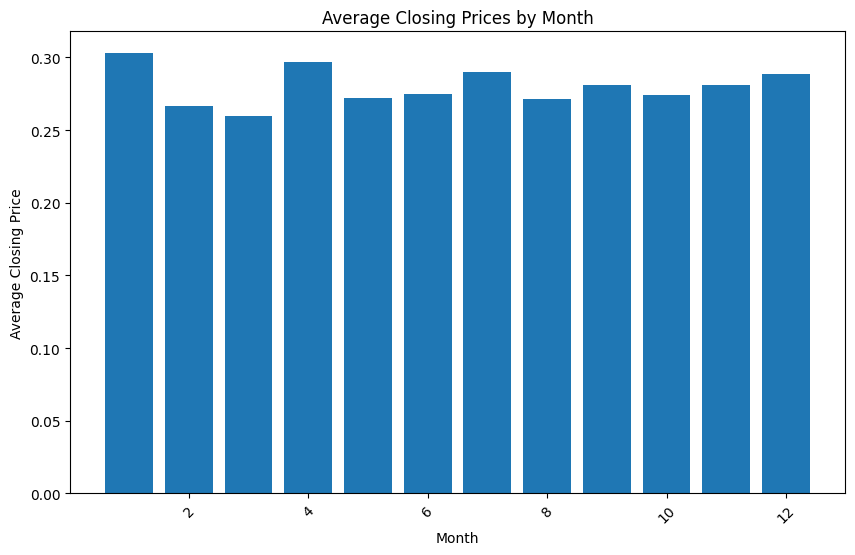

In [11]:
df['Month'] = df['Date'].dt.month

monthly_avg = df.groupby('Month')['Close'].mean()

plt.figure(figsize=(10, 6))
plt.bar(monthly_avg.index, monthly_avg.values)
plt.title('Average Closing Prices by Month')
plt.xlabel('Month')
plt.ylabel('Average Closing Price')
plt.xticks(rotation=45)
plt.show()


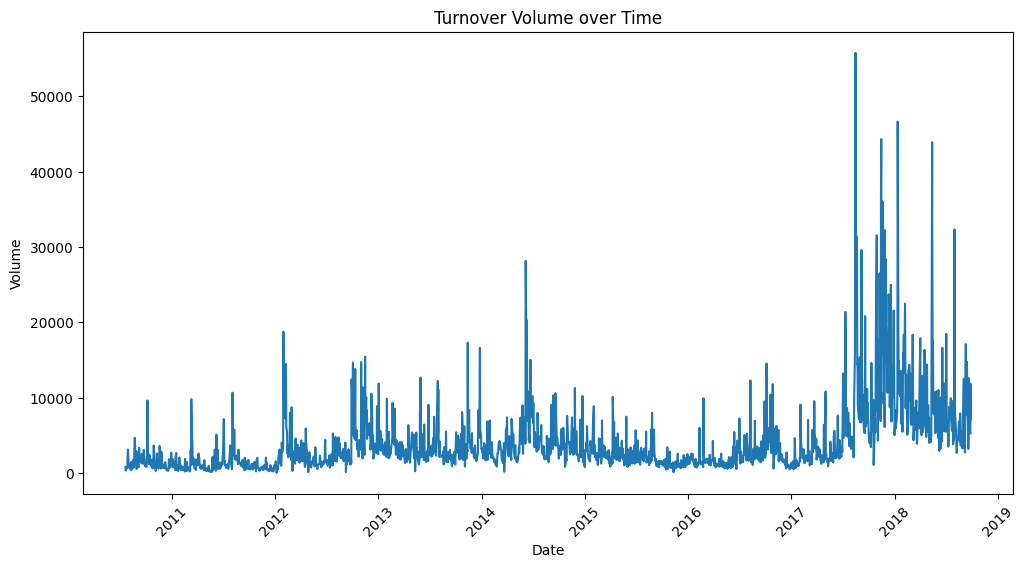

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Turnover (Lacs)'])
plt.title('Turnover Volume over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.show()


### Step 3: Model Training

In [13]:
# Assuming you want to use 80% of the data for training and 20% for testing
train_size = int(len(df) * 0.8)
train_data = df[:train_size]
test_data = df[train_size:]

In [14]:
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

# Assuming you want to use a sequence length of 10
sequence_length = 10

# Creating training sequences
x_train, y_train = create_sequences(train_data['Close'].values, sequence_length)

# Creating testing sequences
x_test, y_test = create_sequences(test_data['Close'].values, sequence_length)


In [15]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
# Assuming you want to train the model for 10 epochs
epochs = 10

# Training the model
model.fit(x_train, y_train, epochs=epochs, batch_size=16, verbose=1)

Epoch 1/10
102/102 [==============================] - 4s 6ms/step - loss: 0.0033
Epoch 2/10
102/102 [==============================] - 1s 6ms/step - loss: 6.6181e-04
Epoch 3/10
102/102 [==============================] - 1s 6ms/step - loss: 6.4178e-04
Epoch 4/10
102/102 [==============================] - 1s 6ms/step - loss: 5.8241e-04
Epoch 5/10
102/102 [==============================] - 1s 6ms/step - loss: 5.8158e-04
Epoch 6/10
102/102 [==============================] - 1s 6ms/step - loss: 5.4838e-04
Epoch 7/10
102/102 [==============================] - 1s 6ms/step - loss: 5.7448e-04
Epoch 8/10
102/102 [==============================] - 1s 6ms/step - loss: 5.1460e-04
Epoch 9/10
102/102 [==============================] - 1s 6ms/step - loss: 4.1761e-04
Epoch 10/10
102/102 [==============================] - 1s 6ms/step - loss: 3.9388e-04


### Step 4: Model Evaluation

In [17]:
# Evaluating the model on the test data
test_loss = model.evaluate(x_test, y_test)

# Printing the test loss
print("Test Loss:", test_loss)

13/13 [==============================] - 1s 2ms/step - loss: 0.0064
Test Loss: 0.00639160443097353


### Step 5: Model Predictions

In [18]:
# Making predictions on the test data
predictions = model.predict(x_test)

# Inverse transforming the predictions and actual values to their original scales
predictions = scaler.inverse_transform(predictions)
actual_values = scaler.inverse_transform(y_test.reshape(-1, 1))

13/13 [==============================] - 1s 2ms/step


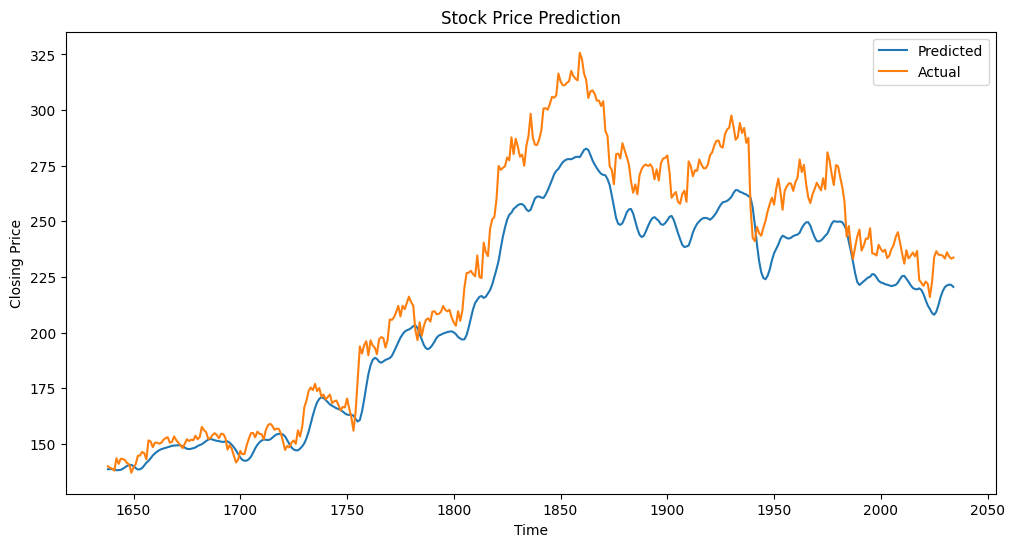

In [19]:
# Visualizing the predictions and actual values
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[sequence_length:], predictions, label='Predicted')
plt.plot(test_data.index[sequence_length:], actual_values, label='Actual')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()